# How good is the food?

*Rafael Cardenas* 

*Disclaimer: This project is still under construction, at this date (19.07.20) the classification algorithm is being fine tunned to increase its performance*

### Project Outline


1. [Problem background and business value](#Problem_Backgound)
2. [Objectives and problem statement](#Objectives)
3. [EDA](#EDA)
4. Methodology
5. Algorithm
6. Conclusions and next Steps

## Background
<a id='Problem_Backgound'><a/>

Sentiment Analysis has raised in parallel with the ammount of opinions on the web. Part of a broader field known as opinion mining, in the early 2000's gained popularity as businesses started to receive more and more feedback for their products in the form of comments.
As data volumes began to increase in size, methods to extract information were developed, sentiment analysis is still considered as a robust one to quantify opinions of the masses.

Fast forward to more recent times, sentiment analysis has extended farther than product reviews; now ranging from *brand perception* to opinion mining in sensible topics such as the elections.

##### Business Value:
At the end of the day, data **science in a company serves the ultimate goal of a business: Profit generation.** Sentiment Analysis has a broad range of applications in the real world. Successful companies mine opinions of a specific brand/product from several sources to quickly know what is popular opinion of the product/brand and identify the possible reasons; with that, companies could make better decisions in difficult times.
In this same vein, businesses can identify which are the most important factors that lead the costumer to incline towards a positive or negative opinion and based on that, make the pertinent moves.


## Objectives and problem statement
<a id='Objectives'></a>

This project has been done from a didactical point of view, approaching the problem with the combination of already existing resources and my own initiative. That being said, I did set specific goals and success metrics for this project:

* No libraries *(NLTK, SpaCy)* NLP pipeline: Self imposed restriction to manually implement text preparation and feature extraction.
* At least 85% accuracy on classification, taking as benchmark papers on Sentiment Analysis **([Pang, et al. 2002](https://www.aclweb.org/anthology/W02-1011/) & [Potts, et al. 2011](https://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf))**
* Deploy the model. ML models that does not go beyond a notebook provide no value to the business, for a model to be useful, an API should be available

##### Problem Statement

The questions that are going to be answer through this analysis.

1. What makes a good/bad review?
2. In which aspects should restaurants improbe to gain/mantain customers?
3. Can we identify fake reviews? i.e reviews written by owners

## Exploratory Data Analysis
<a id='EDA'><a/>

In order to keep the focus of this project on the analysis part of the pipeline, I used the [*Yelp Dataset*](https://www.yelp.com/dataset/download) provided by Yelp.
This part of the documentation focuses on the initial analysis of the data to make myself familiar with the data and make my first assumptions and paths that I could take towards the analysis.

#### Starting with the preprocessing...

In [520]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re

##### Load the 'business' dataset

In [521]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

##### Load the reviews dataset
Merge using ONLY the 'Restaurants' category

In [522]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

Using merge instead of join because we want to join in another column other than the index

In [523]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

##### Finally the data to be preprocessed (the "text" column, to be exact) 
To be done:
* Delete all number 3 i.e neutral 
* Same number of positive as negatives
* Shuffle the data

In [524]:
data.head(2)

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."


In [541]:
"There are: " + str(data.shape[0]) + " reviews on the data set"

'There are: 66698 reviews on the data set'

Text(0.5, 1.0, 'Number of reviews by stars')

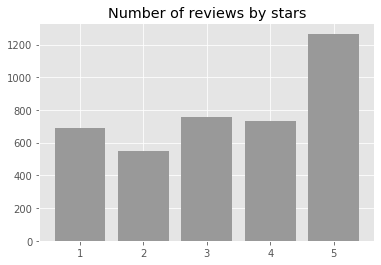

In [555]:
data = data.loc[:, ['name', 'stars', 'text']]
x = (data['stars'].value_counts()).index
y = (data['stars'].value_counts()).values
_ = plt.bar(x, y, color = '#999999')
plt.title("Number of reviews by stars")

**As we can see, the reviews are imbalanced, biased towards positive reviews**

Reviews with "1" and "2" stars fall into the negative (0) category, "4" and "5" in to the positive (1), but as we just saw, there are many more positive revies than negartive, thus, we use "3 stars" as negative (0) to augment the data and  balance the classes


In [546]:
def balance_sample(data, no_samples):
    neg_half = list((data[data['stars'] <=3]).index)
    neg_half = neg_half[:no_samples]
    pos_half = list(set(range(data.shape[0])) - set(neg_half))
    pos_half = pos_half[0:len(neg_half)]
    pos_half.extend(neg_half)
    dropper = list(set(range(data.shape[0])) - set(pos_half))
    data.drop(index = dropper, inplace = True)
    data['Sentiment'] = data['stars'].apply(lambda x: 1 if x > 3 else 0)
balance_sample(data, 2000)

##### Limiting data size
We use the previous function to balance the classes in terms of label and to reduce the number of samples that are going to be processed in the following steps. This was introduced to control the size of the data because of computational limitations. In this case we select 2000

Text(0.5, 1.0, 'Number of reviews by class')

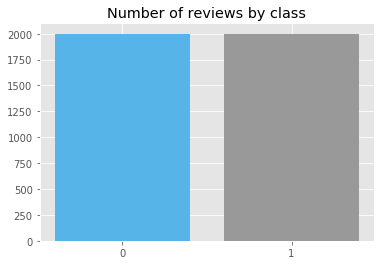

In [554]:
x = (data['Sentiment'].value_counts()).index
y = (data['Sentiment'].value_counts()).values
_ = plt.bar(x, y, color=['#999999','#56B4E9'])
plt.xticks([0,1])
plt.title("Number of reviews by class")

### -------------------------------------------------------------------------------------

### NLP pipeline

![NLP pipeline](https://github.com/rafardenas/How-good-is-the-food-/blob/master/Images/NLP_pipeline.png "Title")

The goal here is to make a bag of words, it can be done manually, but also with sklearn.

**Steps:** I am trying to extract the nest tokens with the tokenizer from Potts and then feed that already "clean tokens" to the vectorizer

### PoC for NLTK

In [14]:
raw = data2['text'][1:3]
raw
raw2 = data2['text'][1]

NameError: name 'data2' is not defined

In [15]:
from nltk.probability import FreqDist
counter = FreqDist()

In [16]:
tokenizer = []
a = 0
for i in raw2:
    words = i.lower()
    words = words.split()
    for word in words:
        a += 1
        counter[word] += 1
        if word not in tokenizer:
            tokenizer.append(word)
len(tokenizer)
tokenizer
words = raw2.split()
for word in words:
    a += 1
len(words)

NameError: name 'raw2' is not defined

### For the negation tagging, put the negation until ^[.:;!?]$ (until the punctuation mark)

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [18]:
#out of the box tokenizer and counter
from nltk.probability import FreqDist
counter = FreqDist()
tokens_nltk = word_tokenize(raw2)

tokenizer = []
for word in tokens_nltk:
    counter[word.lower()] += 1

len(tokens_nltk)
len(counter)
counter['the']

NameError: name 'raw2' is not defined

In [20]:
#counter.B() #is the number of unique words (?)
#x = counter.N #is the number of words
#counter.most_common(20)

In [21]:
stop = set(stopwords.words("english"))

# -------------------------------------------------------------

### Trials for regex

TBD:
### Check the paper that is mentioned in notion by UCLondon

* Delete all the reviews that are not in english
* Same number of negative that as positive reviews for the sets
* Tokenization and BoW creation (**BoW with frequency or with presence?**)
* unigrams and bigrams
* lower the case
* POS tagging?
* EDA como en potts con las palabras mas frecuentes en positives and negatives reviews
* Handling negation? _NOT or with sentiment negative scoring?
* See the book by Bing Lui for how to identify fake news, resonates with anomaly detection and identifying if a review is fake

In [22]:
string = """Hello my Number is 123456789 and  
             my friend's number is 987654321, and my number is also 987654321"""
    
# A sample regular expression to find digits.  
regex = '\d+'             
    
match = re.findall(regex, string)  
print(match)
raw2

['123456789', '987654321', '987654321']


NameError: name 'raw2' is not defined

# ---------------------------------------------------

## Negation tagging Function

In [23]:
def pesimist(text):
    x = text
    x = x.split()
    hasta = 0
    desde = 0
    c = 0
    j = 0
    passer = False
    for k in range(len(x)):
        #print(j)
        #print(k)
        #if not passer:
            #continue
        passer = True

        i = x[k]
        negation_string = r"""
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|but|doesnt|didnt|isnt|arent|aint
        )$|n't
        """
        #print("first")
        c +=1
        #match = re.search(r'\bthe\b',i)
        neg = re.compile(negation_string, re.VERBOSE | re.I | re.UNICODE)
        match = neg.findall(i)
        #print(i + "i")
        #print('desde', desde)
        #print(f'hasta menos desde es: {hasta - desde} y c es {c}')
        if c < (hasta - desde):
            continue
        if match:
            c = 0
            desde = k + 1
            #print(c - 1)
            #j = i
            jump = k
            for j in range(jump, 100):

                #print(j)
                try:
                    comma = re.search(r'[.:;!?]', x[j])
                    #print("second")
                    if comma:
                        hasta = j + 1
                        c += 1
                        
                        #this try to avoid error if there is no punctuation error before the phrase ends
                        try:
                            for i in range(desde, hasta):
                                repl = re.match(r'\w+', x[i])
                                x[i] = repl.group() + "_NOT"
                            
                            c = 0
                            break
                        except:
                            #print(' '.join(x))
                            c = 0
                            break
                except:
                    pass
        if match:
            continue



                #continue


            #else:
                #continue
            #break
    xx = ' '.join(x)
    return xx

## *Already done*
    1. Identify all the negation words on the regular expresion, can be taken from one paper.
    2. Implement it i conjuction with the tokenizer and the stop words removal
    3. run it for all the dataset
    4. Balance the positive and negative classes on the data set that we are going to take to make all the trials.
    5. Finish the identification of features
    


## Current status

order of the pipeline (in **bold** what is already done)

(balance the sample 50/50 in reviews)
1. **Negator**
2. **Tokenizer**
3. **Stop words removal (kind of done, have to figure it out)**
3. **BoW**

*Follows: Select the features and extend the functionality for all the reviews*
1. bigram
2. Positive Tokens
3. Negative Tokens

## Negation tagging

In [383]:
trial = data.copy()

In [384]:
#Apply the function of negation taggin to each row
trial["sample"] = trial.loc[:, "text"].apply(pesimist)

In [385]:
trial.head()

,business_id,name,city,categories,stars,text,Sentiment,sample
0,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,"Japanese, Fast Food, Food Court, Restaurants",5,"Great Sushi, and unbeatable prices! Only downf...",1,"Great Sushi, and unbeatable prices! Only downf..."
1,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,"Japanese, Fast Food, Food Court, Restaurants",3,I don't listen to my father often when it come...,0,I don't listen_NOT to_NOT my_NOT father_NOT of...
2,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",4,"Never heard of the cheese meltdown pretzel, bu...",1,Never heard_NOT of_NOT the_NOT cheese_NOT melt...
3,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",4,"PV Mall's food court needs updating, but that ...",1,"PV Mall's food court needs updating, but that_..."
4,fnZrZlqW1Z8iWgTVDfv_MA,Carl's Jr,Las Vegas,"Mexican, Restaurants, Fast Food",3,I haven't tried much on their menu but their c...,0,I haven't tried_NOT much_NOT on_NOT their_NOT ...


## Tokenizer


In [386]:
from Utils.happyfuntokenizing import Tokenizer

In [468]:
def tiktokens(raw_data):
    """
    Tokenizer function
    """
    raw_data["sample"] = raw_data.loc[:, "text"].apply(pesimist)
    tok = Tokenizer()
    raw_data["tokens"] = raw_data.loc[:, "sample"].apply(tok.tokenize)
    raw_data.reset_index(inplace = True)
    print(raw_data["Sentiment"].value_counts())

In [388]:
tok = Tokenizer()
tok.__dict__

{'preserve_case': False, 'all_in': False}

## Removing 'filler' words
Counting the most common words over all the corpora we can tell that the most common ones, and thus, tne ones that may play a bid role on the classification, are not meaningful for us to discover which words are really expressing a positive or negative emotion, thus, the first 15 words are going to be removed from the corpus.

In the following cells, the most common words are shown

In [427]:
reviews = trial['tokens'].to_numpy()
review1 = reviews[0]
rank = trial['Sentiment'].to_numpy()

In [428]:
rank[0]

1

In [113]:
def most_common_words(raw_reviews, w_number):
    """
    Creates a list with the most 'w_number' (number) of words on the whole corpus
    ---------
    raw_reviews : all the column of the raw reviews
    w_number = number of most common words that wish to be extracted
    """
    
    commons = []
    for word in counting:
        commons.append(word[0])
        if len(commons) == w_number:
            break
    return commons, counter
#cc, count = most_common_words(reviews, 9)


## Bag of words
Using the tokens, of course
* Make the corpora
* Make the vectors with word presence/frecuency. I think presenc may be better for vector-space representation

TBD: check why is not working when the number of ommited words is omre than 1

In [420]:
def restricted_corpus_builder(corpus_size, raw_reviews):
    """
    Create the bag of words with the first 'corpus_size' most common words present on the reviews
    -----------
    corpus_size : number of words to be included on de bow
    raw_reviews : all the column of the raw reviews
    """
    bow = []
    bow_counter = []
    counter = FreqDist()
    for review in raw_reviews:
        for word in review:
            counter[word] += 1
    counting = counter.most_common(corpus_size)
    for word in counting:
        bow.append(word[0])
        bow_counter.append(word[1])
    return bow, bow_counter  
bow, bow_counted = restricted_corpus_builder(3000, reviews)

## Plot showing the big frecuency gap between the most common words and the not so common
The first 100 seem to be the most common among this domain (restaurants)

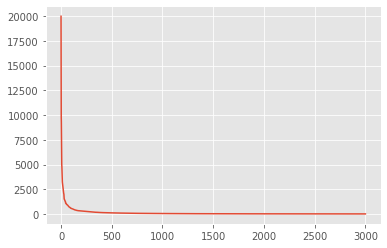

In [421]:
plt.plot((np.linspace(0, len(bow_counted), num=len(bow_counted))), bow_counted)

In [394]:
'''
for word, numb in enumerate(zip(bow, bow_counted)):
    print(word, numb)
'''

'\nfor word, numb in enumerate(zip(bow, bow_counted)):\n    print(word, numb)\n'

In [342]:
def corpus_builder(raw_reviews, most_common):
    """
    Create the bag of words of all the words present on the reviews, ommiting the 'most_common' words as they are 
    conseidered as fillers with low influence on the classification
    -----------
    raw_reviews : all the column of the raw reviews
    most_common : list of most common words that wish to be ommited
    """
    main_corpus = []
    for review in raw_reviews:
        for word in review:
            if word in most_common:
                continue
            if word not in main_corpus:
                main_corpus.append(word)
    return main_corpus
#bow = corpus_builder(reviews, cc)
#len(bow)

In [343]:
def vectorizer(bow, ind_review, ommitted_words):
    """
    Vectorize the review based on the counting of the words present on the review, 
    the appereances are counted on a dictionary, the value of the words (keys) that are not present remain as '0'
    ----------
    bow : bag of all the words in list (unique values)
    ind_review = indiviual review to be vectorized
    ommited_words: number of most common words that are going to be ommited
    """
    ommitted = bow[:ommitted_words]
    bow = bow[ommitted_words:]
    counter = dict.fromkeys(bow, 0)
    for word in ind_review:
        try:
            if word in ommitted_words:
                continue
            else:
                counter[word] += 1
        except:
            pass
    return list(counter.values()), ommitted
#vv = vectorizer(bow, review1, cc)

In [344]:
def matrix_builder(bow, review_series, ommited_words):
    """
    Creates the matrix of features based on the term frecuency vectors created by the function vectorizer
    ----------
    bow: bag of words
    review_series : pandas object (series)  i.e dataframe[name_of_column]
    ommited_words: number of most common words that are going to be ommited
    """
    X = []
    i = 0
    
    for review in review_series:
        word_vector, ommitted = vectorizer(bow, review, ommited_words)
        if i < 1:
            X = np.array([word_vector])
            i += 1
            continue
        X = np.append(X, [word_vector], axis = 0)
    print(ommitted)
    return X

### Pipeline for the creation of the feature matrix
* features thus far: 
    * unigram i.e. word frecuency 

In [39]:
reviews = trial['tokens'].to_numpy()
common = most_common_words(reviews, 9)
bow = corpus_builder(reviews, common)
raw_reviews = trial['tokens']
X = matrix_builder(bow, raw_reviews, common)
X.shape

NameError: name 'counting' is not defined

## General Pipeline

1. Data
2. Tokens
3. Bow
3. Features (aka Matrix builder)
4. Classifiers

In [508]:
data2 = data.copy()
balance_sample(data2, 100)
tiktokens(data2)

1    100
0    100
Name: Sentiment, dtype: int64


In [483]:
features = data2['tokens'].to_numpy()
y = data2['Sentiment'].to_numpy()

In [476]:
#Construct the feature matrix (vectors)
common = 0
X = matrix_builder(bow, features, common)

[]


In [484]:
print(X.shape,"|||", y.shape)

(200, 3000) ||| (200,)


### From here start the classifier

* To start we are going to work only with unigrams, then we can add a lexicon to determine the sentiment score and use that as feature or also try with bigrams or somethign along those lines

In [485]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
clf = SVC(C = 1e-5, kernel = 'linear')

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33) 

In [506]:
clf.fit(X_train, y_train)

SVC(C=1e-05, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [517]:
clf.score(X_test, y_test)

0.48484848484848486

In [433]:
prediction = clf.predict(X_test)
accu = accuracy_score(y_test, prediction)

In [434]:
accu

0.49393939393939396

In [515]:
from sklearn.naive_bayes import MultinomialNB
clf2 = MultinomialNB()
clf2.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [516]:
clf2.score(X_test, y_test)

0.48484848484848486